In [1]:
import sys
sys.path.insert(0, '../')
from gw_tools.gw_plot import gw_plot
from gw_tools import data_prep
from gw_tools.gw_cnn import gw_cnn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
## Define CNN parameters for individual wells
## RMSE: 2.3402760903147106
params_AEK201 = {'model__BATCH_SIZE': 32,
                 'model__C1_FILTERS': 64,
                 'model__C1_KERNEL': 16,
                 'model__C1_LAYER': True,
                 'model__C2_FILTERS': 64,
                 'model__C2_KERNEL': 12,
                 'model__C2_LAYER': True,
                 'model__C3_FILTERS': 64,
                 'model__C3_KERNEL': 36,
                 'model__C3_LAYER': True,
                 'model__D_MAX_LAYERS': 8,
                 'model__D_MIN_UNITS': 3,
                 'model__D_TOP_UNITS': 150,
                 'model__D_UNIT_SCALE': 0.75,
                 'model__EPOCHS': 100,
                 'model__LEARNING_RATE': 0.001,
                 'model__STOP_DELTA': 0.1}

## RMSE: 2.45326918726607
params_AFL259 = {'model__BATCH_SIZE': 32,
                 'model__C1_FILTERS': 32,
                 'model__C1_KERNEL': 8,
                 'model__C1_LAYER': True,
                 'model__C2_FILTERS': 128,
                 'model__C2_KERNEL': 24,
                 'model__C2_LAYER': True,
                 'model__C3_FILTERS': 64,
                 'model__C3_KERNEL': 18,
                 'model__C3_LAYER': True,
                 'model__D_MAX_LAYERS': 8,
                 'model__D_MIN_UNITS': 3,
                 'model__D_TOP_UNITS': 150,
                 'model__D_UNIT_SCALE': 0.75,
                 'model__EPOCHS': 100,
                 'model__LEARNING_RATE': 0.001,
                 'model__STOP_DELTA': 0.1}

## RMSE: 1.9353950671555313
params_APK309 = {'model__BATCH_SIZE': 32,
                 'model__C1_FILTERS': 16,
                 'model__C1_KERNEL': 8,
                 'model__C1_LAYER': True,
                 'model__C2_FILTERS': 32,
                 'model__C2_KERNEL': 24,
                 'model__C2_LAYER': True,
                 'model__C3_FILTERS': 64,
                 'model__C3_KERNEL': 18,
                 'model__C3_LAYER': True,
                 'model__D_MAX_LAYERS': 8,
                 'model__D_MIN_UNITS': 3,
                 'model__D_TOP_UNITS': 150,
                 'model__D_UNIT_SCALE': 0.75,
                 'model__EPOCHS': 100,
                 'model__LEARNING_RATE': 0.001,
                 'model__STOP_DELTA': 0.1} 

## RMSE: 2.416546971184388
params_APK310 = {'model__BATCH_SIZE': 32,
                 'model__C1_FILTERS': 32,
                 'model__C1_KERNEL': 8,
                 'model__C1_LAYER': True,
                 'model__C2_FILTERS': 128,
                 'model__C2_KERNEL': 24,
                 'model__C2_LAYER': True,
                 'model__C3_FILTERS': 64,
                 'model__C3_KERNEL': 18,
                 'model__C3_LAYER': True,
                 'model__D_MAX_LAYERS': 8,
                 'model__D_MIN_UNITS': 3,
                 'model__D_TOP_UNITS': 150,
                 'model__D_UNIT_SCALE': 0.75,
                 'model__EPOCHS': 100,
                 'model__LEARNING_RATE': 0.001,
                 'model__STOP_DELTA': 0.1}

well_params = [params_AEK201, params_AFL259, params_APK309, params_APK310]

In [3]:
wells = ['AEK201', 'AFL259', 'APK309', 'APK310']
def standard_prep(well):
    ## Load cleaned data
    df = data_prep.load_data(well)
    ## Select features for training
    df = data_prep.select_features(df)
    ## Add time of year signal information
    df = data_prep.add_toy_signal(df)
    ## Set aside holdout data for final model validation
    return data_prep.prep_data_for_training(df)

# Convoltional Neural Network

One of the deep learning frameworks we implemented for this project is a convolutional neural newtork (CNN). While these networks are not commonly associated with time series data, we did find examples of implementaions to problems that has some similarities to ours. We were curoious whether these tools could be applied here. 

Because Scikit-Learn does not have any modules for contructing CNNs, we turned to packeges provided by Keras to build our newtork. We were still intersted in using Scikit-Learn tools like Pipeline and GridSearchCV, so we needed to make a custom Scikit-Learn Estimator/Transformser to make the `fit` and `predict` functions of our model accessible them.

The CNN's we explored all shared the same basic sequential structure:

- An input layer
- Some Convolutional (Conv1D) layers
- A flattening layer
- Some hidden Dense layers (all with rectified linear activation functions)
- An Dense output layer

We used GridSearchCV to fine tune the follwing hyper-parameters for each well:

- Batch size
- Number of one dimensional convolutional layers. Then, within each of these layers:
    - Kernel Size
    - Filter size
- The number and structure of the hidden Dense layers, by adjusting:
    - The number of units in the first Dense Layer
    - The number of units in each dense successive Dense layer, relative to number of units in the previous Dense layer
    - The maximum number of Dense layers
    - The minimum units in the last hidden Dense layer
- The number of Epochs to train for each set of parameters
- The learning rate (using the Adam optimizer)
- An EarlyStopping parameter dictating how much loss improvement was needed to continue training, with a patience of three epochs.

This hyperparmeter tuning was mostly perfomed with TimeSeriesSplit cross validation of at least 3 splits (with a 365 day test set). Though, some later tuning exploration was done without any cross validation due to the computational time involved.

2023-11-20 20:14:59.018166: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2023-11-20 20:14:59.018184: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2023-11-20 20:14:59.018190: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2023-11-20 20:14:59.018218: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-20 20:14:59.018231: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2023-11-20 20:14:59.537110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


124/124 [==============================] - 2s 9ms/step - loss: 742.7554
Epoch 2/100
124/124 [==============================] - 1s 6ms/step - loss: 75.8852
Epoch 3/100
124/124 [==============================] - 1s 6ms/step - loss: 9.2528
Epoch 4/100
124/124 [==============================] - 1s 7ms/step - loss: 3.0244
Epoch 5/100
124/124 [==============================] - 1s 7ms/step - loss: 2.4874
Epoch 6/100
124/124 [==============================] - 1s 6ms/step - loss: 1.2998
Epoch 7/100
124/124 [==============================] - 1s 6ms/step - loss: 1.1162
Epoch 8/100
124/124 [==============================] - 1s 6ms/step - loss: 0.9761
Epoch 9/100
124/124 [==============================] - 1s 7ms/step - loss: 0.8007
Epoch 10/100
124/124 [==============================] - 1s 7ms/step - loss: 0.7320
Epoch 11/100
124/124 [==============================] - 1s 6ms/step - loss: 0.7172
Epoch 12/100
124/124 [==============================] - 1s 7ms/step - loss: 0.7376
Epoch 13/100
124/124 [

2023-11-20 20:15:13.924507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


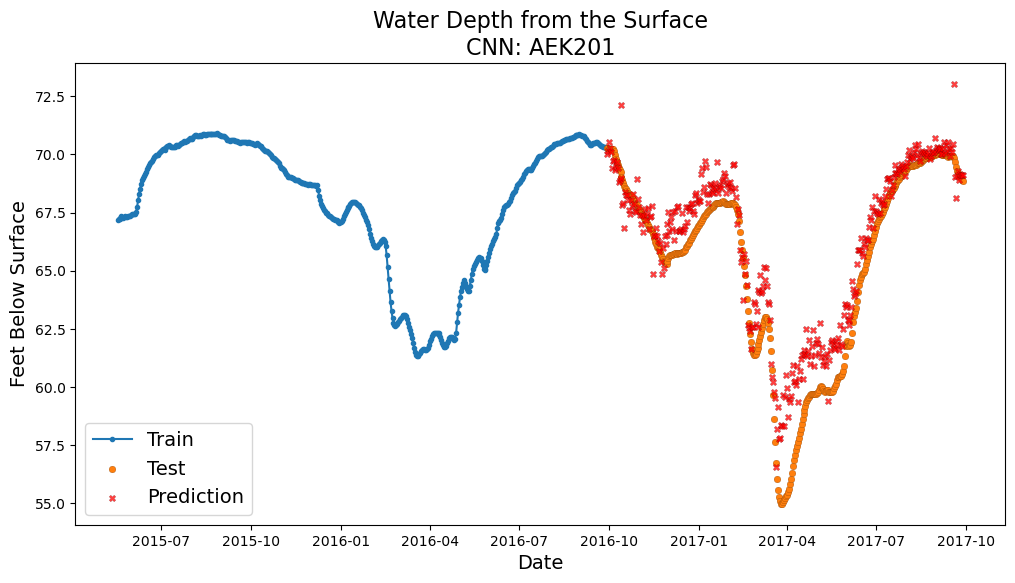

Epoch 1/100
  1/124 [..............................] - ETA: 47s - loss: 8335.2021

2023-11-20 20:15:14.551783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


124/124 [==============================] - 1s 8ms/step - loss: 1368.3646
Epoch 2/100
124/124 [==============================] - 1s 7ms/step - loss: 220.6798
Epoch 3/100
124/124 [==============================] - 1s 7ms/step - loss: 37.4560
Epoch 4/100
124/124 [==============================] - 1s 7ms/step - loss: 10.1969
Epoch 5/100
124/124 [==============================] - 1s 7ms/step - loss: 7.0835
Epoch 6/100
124/124 [==============================] - 1s 7ms/step - loss: 6.5931
Epoch 7/100
124/124 [==============================] - 1s 6ms/step - loss: 5.7241
Epoch 8/100
124/124 [==============================] - 1s 6ms/step - loss: 5.7454
Epoch 9/100
124/124 [==============================] - 1s 6ms/step - loss: 5.6689
Epoch 10/100
124/124 [==============================] - 1s 6ms/step - loss: 6.7538
Epoch 11/100
124/124 [==============================] - 1s 6ms/step - loss: 4.9759
Epoch 12/100
124/124 [==============================] - 1s 7ms/step - loss: 5.5202
Epoch 13/100
124/1

2023-11-20 20:15:27.277585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


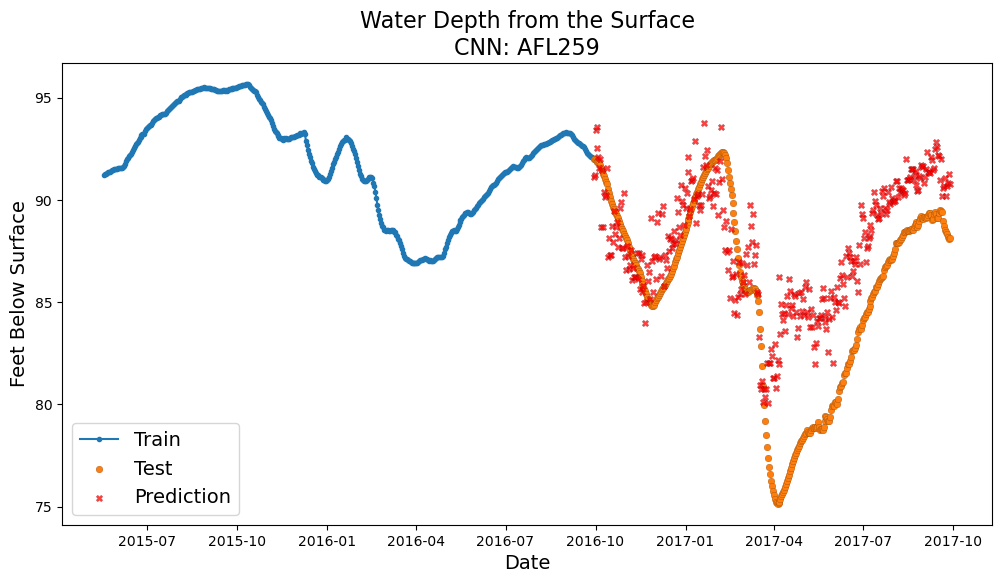

Epoch 1/100


2023-11-20 20:15:27.872931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


115/115 [==============================] - 1s 8ms/step - loss: 401.3223
Epoch 2/100
115/115 [==============================] - 1s 7ms/step - loss: 66.9596
Epoch 3/100
115/115 [==============================] - 1s 7ms/step - loss: 18.7098
Epoch 4/100
115/115 [==============================] - 1s 7ms/step - loss: 3.5983
Epoch 5/100
115/115 [==============================] - 1s 7ms/step - loss: 1.9441
Epoch 6/100
115/115 [==============================] - 1s 7ms/step - loss: 1.4739
Epoch 7/100
115/115 [==============================] - 1s 7ms/step - loss: 1.2869
Epoch 8/100
115/115 [==============================] - 1s 7ms/step - loss: 1.2254
Epoch 9/100
115/115 [==============================] - 1s 7ms/step - loss: 0.9725
Epoch 10/100
115/115 [==============================] - 1s 7ms/step - loss: 0.9581
Epoch 11/100
115/115 [==============================] - 1s 7ms/step - loss: 1.0029
Epoch 12/100
115/115 [==============================] - 1s 7ms/step - loss: 0.8862
Epoch 13/100
115/115 

2023-11-20 20:15:41.987966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


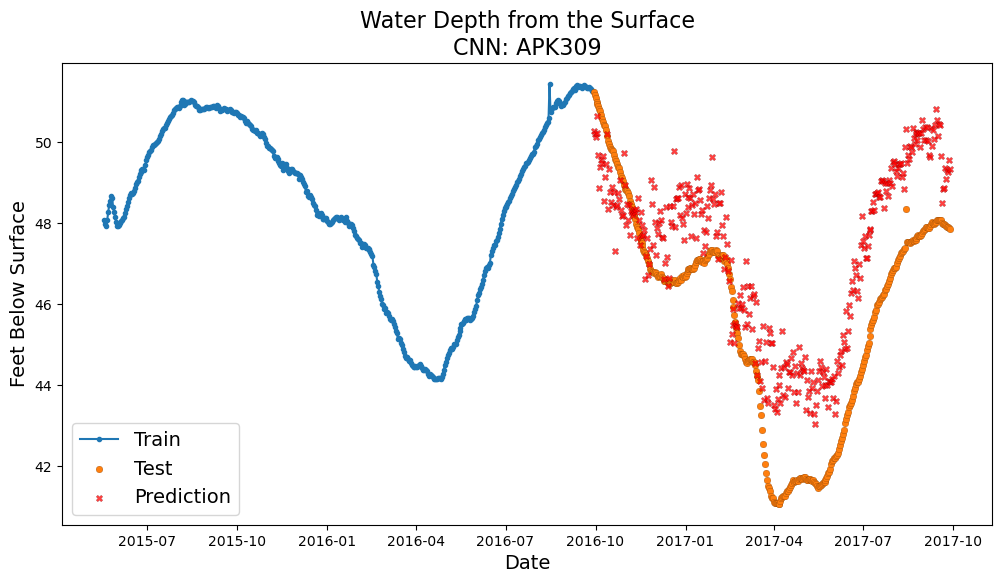

Epoch 1/100


2023-11-20 20:15:42.586793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


113/113 [==============================] - 1s 8ms/step - loss: 2183.7297
Epoch 2/100
113/113 [==============================] - 1s 7ms/step - loss: 233.5395
Epoch 3/100
113/113 [==============================] - 1s 7ms/step - loss: 21.6729
Epoch 4/100
113/113 [==============================] - 1s 7ms/step - loss: 6.9372
Epoch 5/100
113/113 [==============================] - 1s 7ms/step - loss: 4.6371
Epoch 6/100
113/113 [==============================] - 1s 8ms/step - loss: 3.8114
Epoch 7/100
113/113 [==============================] - 1s 7ms/step - loss: 4.7737
Epoch 8/100
113/113 [==============================] - 1s 7ms/step - loss: 4.2386
Epoch 9/100
113/113 [==============================] - 1s 7ms/step - loss: 2.6065
Epoch 10/100
113/113 [==============================] - 1s 7ms/step - loss: 3.5430
Epoch 11/100
113/113 [==============================] - 1s 7ms/step - loss: 2.7461
Epoch 12/100
113/113 [==============================] - 1s 7ms/step - loss: 2.9056
Epoch 13/100
12/12 

2023-11-20 20:15:53.145911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


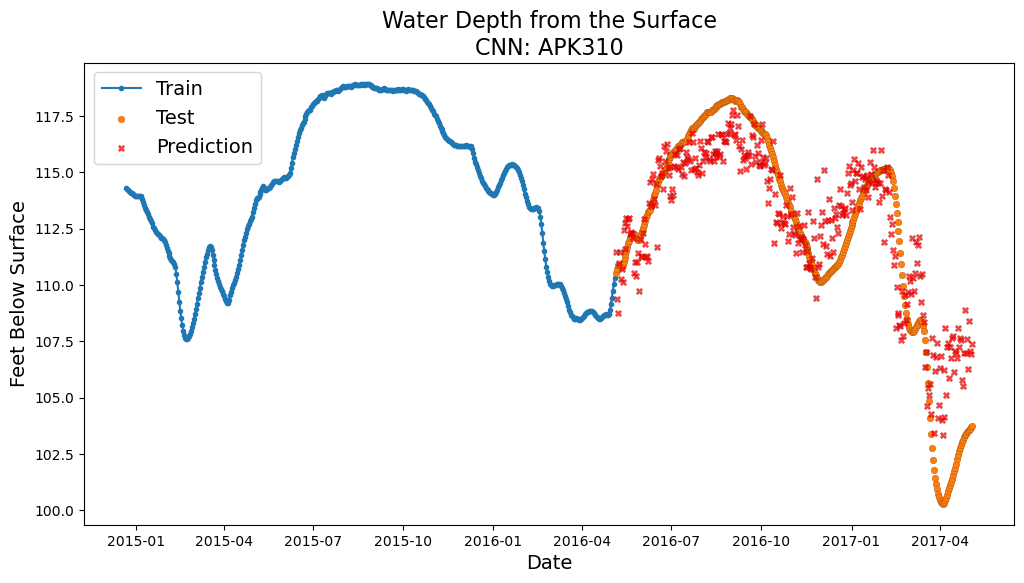

In [4]:
## For scaling the data
scaler =  StandardScaler(copy=True)

for well, params in zip(wells, well_params):
    ## Prepare the training and holdout data
    X_train, X_holdout, y_train, y_holdout, dt_train, dt_holdout = standard_prep(well)
    ## Instantiate the model
    model = gw_cnn()
    ## Set up the pipeline
    pipe = Pipeline([('scaler', scaler), ('model', model)])
    ## Set the parameters
    pipe.set_params(**params)
    ## Fit the model
    pipe.fit(X_train, y_train)
    ## Make predictions
    pred = pipe.predict(X_holdout)
    ## Compute RMSE
    mse = np.mean((pred-y_holdout)**2)
    rmse = np.sqrt(mse)
    ## Print results
    print(f'On the holdout set for {well}, the predictions made using LinearRegression exhibited a root mean squared of {rmse}')
    ## Plot results
    dates = np.append(dt_train, dt_holdout)
    gw_plot(train = y_train, test = y_holdout, pred = pred, dates = dates, train_limit=500, model='CNN: '+well)